# Use the sum of the mCpG values instead of the CpG unit profiles for each read

In [1]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
import time
import shap

import sklearn

# import shap


In [2]:
CGs_all_silenced = np.load("/home/michalula/code/epiCausality/epiCode/notebooks_debug/dimelo_v2_output/CG_142_units_combined_LOW_high_K562_nCATS_20241226_numFWD1576_numRVS1339_padded_reads_LOW_high_K562_nCATS_20241226_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-07.npy")
    # "/home/michalula/code/epiCausality/epiCode/dimelo_v2_output/CG_142_units_combined_silenced_T_primerES_nCATS_numFWD5860_numRVS4229_padded_reads_silenced_T_primerES_nCATS_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-04.npy")

CGs_all_silenced, CGs_all_silenced.shape

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan,  1.],
        [nan, nan, nan, ..., nan, nan,  1.],
        [nan, nan, nan, ..., nan, nan,  1.]]),
 (2915, 142))

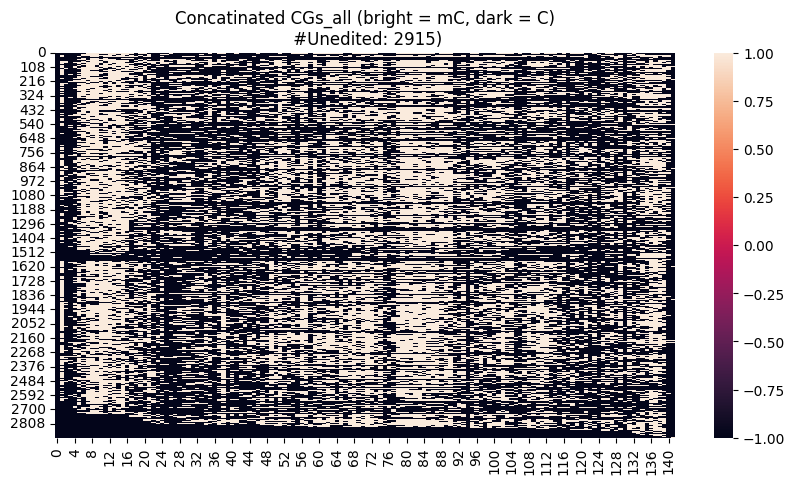

In [3]:
# plot X_unedited_silenced 

# Heatmap of CGs_all
plt.figure(figsize=(10, 5))
sns.heatmap(pd.DataFrame(CGs_all_silenced).fillna(-1))
plt.title(f"Concatinated CGs_all (bright = mC, dark = C)\n #Unedited: {CGs_all_silenced.shape[0]})")
plt.show()


In [4]:
CGs_all_unedited = np.load("/home/michalula/code/epiCausality/epiCode/notebooks_debug/dimelo_v2_output/CG_142_units_combined_unedited_K562_R9P2_nCATS_2024927_numFWD240_numRVS57_padded_reads_unedited_K562_R9P2_nCATS_2024927_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-07.npy")
    # "/home/michalula/code/epiCausality/epiCode/dimelo_v2_output/CG_142_units_combined_unedited_T_primerES_nCATS_numFWD1940_numRVS1599_padded_reads_unedited_T_primerES_nCATS_mCthresh0.9_t2t_v1_1_chr1:206583000-206590000_2025-02-04.npy")

CGs_all_unedited, CGs_all_unedited.shape

(array([[nan,  1., nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan,  1.]]),
 (297, 142))

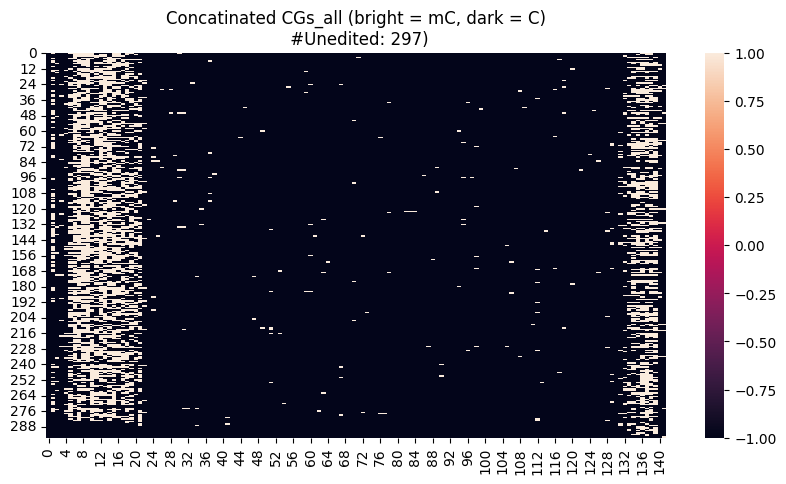

In [5]:
# plot X_unedited_silenced 

# Heatmap of CGs_all
plt.figure(figsize=(10, 5))
sns.heatmap(pd.DataFrame(CGs_all_unedited).fillna(-1))
plt.title(f"Concatinated CGs_all (bright = mC, dark = C)\n #Unedited: {CGs_all_unedited.shape[0]})")
plt.show()
